# Naive Bayes - custom problem

In [1]:
%pylab inline
import pandas as pd
import os

DATASET_PATH = './dataset/toy_dataset.csv'
df = pd.read_csv(DATASET_PATH)

Populating the interactive namespace from numpy and matplotlib


## Data Exploration
This time, we will try to use the Naive Bayes algorithm on a custom dataset, available [here](https://www.kaggle.com/carlolepelaars/toy-dataset/version/1).

Before, we proceed, let's take a look at the data, and see how it is distributed.

In [2]:
df.head()

,Number,City,Gender,Age,Income,Illness
0,1,Dallas,Male,41,40367.0,No
1,2,Dallas,Male,54,45084.0,No
2,3,Dallas,Male,42,52483.0,No
3,4,Dallas,Male,40,40941.0,No
4,5,Dallas,Male,46,50289.0,No


In [3]:
print ("Number of examples: {}.".format(df.shape[0]))

Number of examples: 150000.


### Target - Illness

In [4]:
df.groupby(by='Illness')['Number'].count().sort_values(ascending=False) / len(df)

Illness
No     0.919073
Yes    0.080927
Name: Number, dtype: float64

Illness denotes the occurrence of the event and can be interpreted as as a probabliity:
$p(y)$.
This is a highly skewed dataset, since only less than 1% in the dataset population was labelled as 'sick'.

### Features
We have four featues in the dataset:
* $x_0$: city
* $x_1$: gender
* $x_2$: age
* $x_3$: income

Let's inspect their distributions.

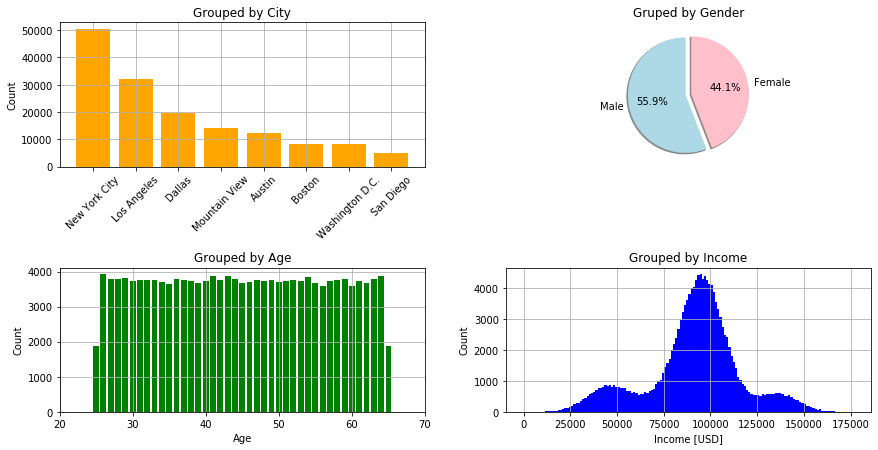

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
fig.tight_layout(h_pad=8, w_pad=5)

axs[0, 0].bar(
    df.groupby(by='City')['Number'].count().sort_values(ascending=False).index.tolist(),
    df.groupby(by='City')['Number'].count().sort_values(ascending=False),
    facecolor='orange')
axs[0, 0].set_xticklabels(
    df.groupby(by='City')['Number'].count().sort_values(ascending=False).index.tolist(),
    rotation=45)
axs[0, 0].set_ylabel("Count")
axs[0, 0].set_title("Grouped by City")
axs[0, 0].grid()

axs[0, 1].pie(
    df.groupby(by='Gender')['Number'].count().sort_values(ascending=False),
    colors=['lightblue', 'pink'],
    labels=df.groupby(by='Gender')['Number'].count().sort_values(ascending=False).index,
    autopct='%1.1f%%',
    explode=(0.05, 0.05),
    startangle=90,
    shadow=True)
axs[0, 1].set_title('Gruped by Gender')

axs[1, 0].bar(
    df.groupby(by='Age')['Number'].count().sort_values(ascending=False).index.tolist(),
    df.groupby(by='Age')['Number'].count().sort_values(ascending=False),
    facecolor='green')

axs[1, 0].set_xlabel('Age')
axs[1, 0].set_xlim([20, 70])
axs[1, 0].set_title("Grouped by Age")
axs[1, 0].set_ylabel('Count')
axs[1, 0].grid()

axs[1, 1].hist(df['Income'], 150, color="blue")
axs[1, 1].set_xlabel('Income [USD]')
axs[1, 1].set_ylabel('Count')
axs[1, 1].set_title("Grouped by Income")
axs[1, 1].grid()

plt.show()

There are eight categories within the `City` feature. The (unconditional) probablility of selecting one city from the dataset can be expressed as $p(x_0) = \frac{\text{number of counts}}{\text{number of all cities}}$.

Similarly, we can calulate $p(x_1)$ and $p(x_2)$.

However, when it comes to the `Income` feature ($x_3$), it makes more sense to find a _probablility density function_ that is continuous. Otherwise, there is too much of a chance that given a particular salary, the prediction would fail due to lack of representation of this very number.

Once could argue that for `Age` ($x_2$) this situation might also occur.
By inspecting the plot, however, we can see that the number of counts is continuous across the age for any number $25 \le x \le 65$. We can therefore, safely limit the fealibility of the model to that interval.

## Formulating evidence probablilities $p(x)$
### Easy features

In [6]:
# x0 - city
prob_x0 = df.groupby(by='City')['Number'].count().sort_values(ascending=False)/df.shape[0]
assert np.sum(prob_x0) == 1.0

In [7]:
# x1 - sex
prob_x1 = df.groupby(by='Gender')['Number'].count().sort_values(ascending=False)/df.shape[0]
assert np.sum(prob_x1) == 1.0

In [8]:
# x2 - age
prob_x2 = df.groupby(by='Age')['Number'].count().sort_values(ascending=False)/df.shape[0]
assert np.sum(prob_x2) == 1.0

### Formulating probablility density function

The distributon of $x_3$ count looks interesting. Actually, it looks like we have three Gaussian distributions that are superimposed. Let's see if we can reconstruct it!

In [9]:
def gaussian(x, mu, sigma, A=1.0):
    return A/(np.sqrt(2*np.pi)*sigma)*np.exp(-0.5*(x - mu)**2 / (sigma**2))

step=0.01
assert abs(gaussian(np.arange(-70, 70, step=step), 1, 1).sum()*step - 1.0) < 0.0000001

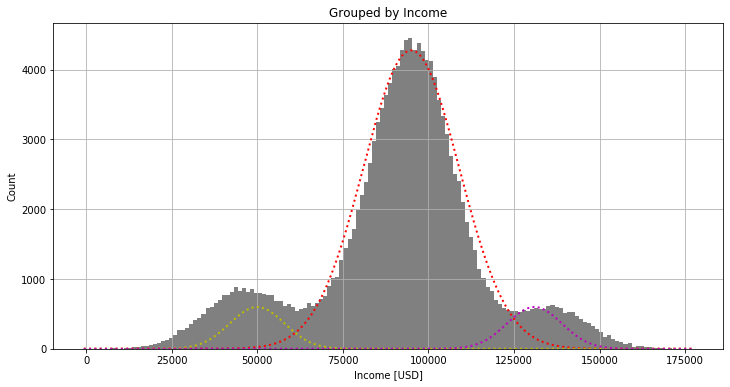

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(df['Income'], 150, color="gray")
ax.set_xlabel('Income [USD]')
ax.set_ylabel('Count')
ax.set_title("Grouped by Income")
ax.grid()

xlist = np.arange(df['Income'].min(), df['Income'].max(), step=100)
ax.plot(xlist, gaussian(xlist, 95000, 14000, A=150000000), ':r', lw=2)
ax.plot(xlist, gaussian(xlist, 50000, 8000, A=12000000), ':y', lw=2)
ax.plot(xlist, gaussian(xlist, 131000, 8000, A=12000000), ':m', lw=2)

plt.show()

The dotted curves were tried by guessing of the input parameters.
For reconstructing of the `Income` probablility distribution, we will use simple curve-fitting method avaliable through `scipy`.
We can use the knowledge from our "manual" fitting attempt to try to correctly _initialize_ of the parameters.

In [11]:
from scipy import optimize
def income_test(x, mu0, mu1, mu2, s0, s1, s2, A0, A1, A2):
    gauss1 = gaussian(x, mu0, s0, A0)
    gauss2 = gaussian(x, mu1, s1, A1)
    gauss3 = gaussian(x, mu2, s2, A2)
    return gauss1 + gauss2 + gauss3

xdata = np.arange(0, 2e5, step=1000)
ydata = df.groupby(pd.cut(df['Income'], xdata))['Number'].count().to_numpy()
xdata = xdata[1:] # fix for array length

# initial guess
mus    = [95000, 50000, 131000]
sigmas = [14000, 8000, 8000]
As     = [200000000, 15000000, 15000000]
p0     = [mus[0], mus[1], mus[2], sigmas[0], sigmas[1], sigmas[2], As[0], As[1], As[2]]
params, pcov = optimize.curve_fit(income_test, xdata, ydata, p0=p0)

assert abs(np.sum(income_test(xdata, *params)/income_test(xdata, *params).sum()) - 1.0) < 0.00001

Here, we pack `Income` variable into 1000-dollar wide bins, counting the number of times a salary of $x$ occurred in each bin. Note, that 1000 is an arbitrary choice. For values much considerably lower than 1000, we create "gaps" in the distribution, while for higher values, the distribution becomes imprecise. Either case, it would lead into degradation in performance.

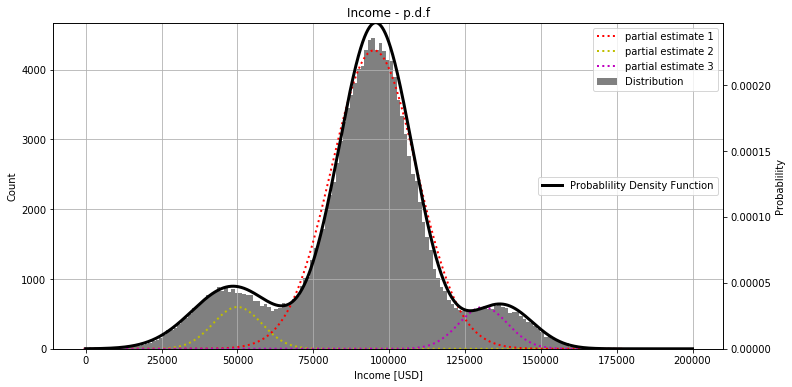

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(df['Income'], 150, color="gray")
ax.set_xlabel('Income [USD]')
ax.set_ylabel('Count')
ax.set_title("Income - p.d.f")
ax.grid()

xlist = np.arange(df['Income'].min(), df['Income'].max(), step=100)
ax.plot(xlist, gaussian(xlist, 95000, 14000, A=150000000), ':r', lw=2)
ax.plot(xlist, gaussian(xlist, 50000, 8000, A=12000000), ':y', lw=2)
ax.plot(xlist, gaussian(xlist, 131000, 8000, A=12000000), ':m', lw=2)
ax.legend(['partial estimate 1', 'partial estimate 2', 'partial estimate 3', 'Distribution'], loc='upper right')

ax2 = ax.twinx()
xline = np.arange(0, 2e5, step=10)
yline = income_test(xline, *params)
prob_x3 = yline/yline.sum()             # <- here is the probablility (as numpy array)
ax2.plot(xline, prob_x3, 'k', lw=3)
ax2.set_ylim([0.0, prob_x3.max()])
ax2.set_ylabel('Probablility')
ax2.legend(['Probablility Density Function'], loc='right')

plt.show()

In order for our synthesized curve to interpretable as a probablity, we need to ensure that $\int_{-\infty}^{\infty} p(x) \text{d}x = 1$.
Numerically, this is achived by dividing of the curve by the elementwise sum within the relevant interval.

## Likelihood functions $p(x|y)$
The likelihood functions denote the probablility that we pick, let's say a `Female`, given that she was ill.
Programatically, this means repeating of the last steps, but with prior selection of the subset, based on that $y=1$.

### Easy features

In [13]:
# x0 - city
total = df[df['Illness'] == 'Yes'].shape[0]
prob_cond_x0 = (df[df['Illness'] == 'Yes'].groupby(by='City')['Number'].count().sort_values(ascending=False)/total)
assert np.sum(prob_cond_x0) == 1.0

In [14]:
# x1 - sex
total = df[df['Illness'] == 'Yes'].shape[0]
prob_cond_x1 = (df[df['Illness'] == 'Yes'].groupby(by='Gender')['Number'].count().sort_values(ascending=False)/total)
assert np.sum(prob_cond_x1) == 1.0

In [15]:
# x2 - age
total = df[df['Illness'] == 'Yes'].shape[0]
prob_cond_x2 = (df[df['Illness'] == 'Yes'].groupby(by='Age')['Number'].count().sort_values(ascending=False)/total)
assert np.sum(prob_cond_x2) == 1.0

### Formulating probablility density function

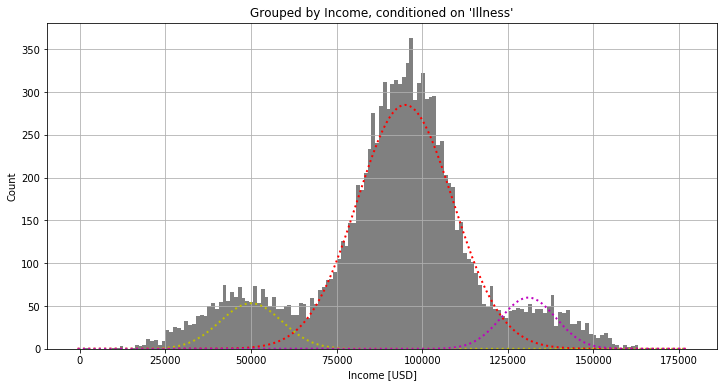

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(df[df['Illness'] == 'Yes']['Income'], 150, color="gray")
ax.set_xlabel('Income [USD]')
ax.set_ylabel('Count')
ax.set_title("Grouped by Income, conditioned on 'Illness'")
ax.grid()

xlist = np.arange(df['Income'].min(), df['Income'].max(), step=100)
ax.plot(xlist, gaussian(xlist, 95000, 14000, A=10000000), ':r', lw=2)
ax.plot(xlist, gaussian(xlist, 50000, 9000, A=1200000), ':y', lw=2)
ax.plot(xlist, gaussian(xlist, 131000, 8000, A=1200000), ':m', lw=2)

plt.show()

Inspecting the plot, we see the distribution is very similar. We can therefore repeat the same approach. Note that the initial parameters are a bit different.

In [17]:
xdata2 = np.arange(0, 2e5, step=1000)
ydata2 = df[df['Illness'] == 'Yes'].groupby(pd.cut(df[df['Illness'] == 'Yes']['Income'], xdata2))['Number'].count().to_numpy()
xdata2 = xdata2[1:] # fix for array length

# initial guess
mus    = [95000, 50000, 131000]
sigmas = [14000, 9000, 8000]
As     = [10000000, 1200000, 12000000]
p0     = [mus[0], mus[1], mus[2], sigmas[0], sigmas[1], sigmas[2], As[0], As[1], As[2]]
params2, pcov = optimize.curve_fit(income_test, xdata2, ydata2, p0=p0)

assert abs(np.sum(income_test(xdata2, *params2)/income_test(xdata2, *params2).sum()) - 1.0) < 0.000000000000001

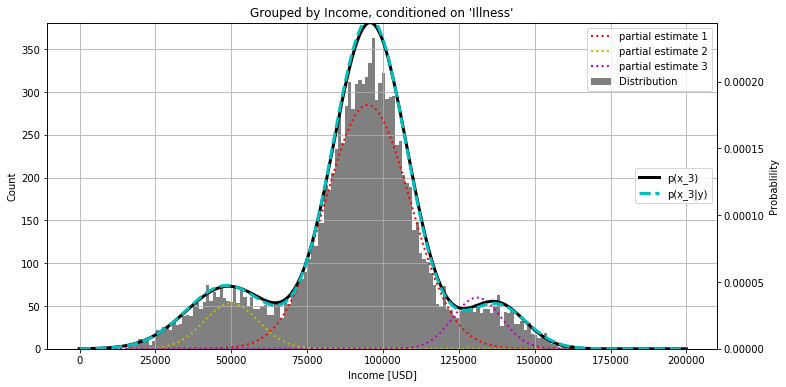

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(df[df['Illness'] == 'Yes']['Income'], 150, color="gray")
ax.set_xlabel('Income [USD]')
ax.set_ylabel('Count')
ax.set_title("Grouped by Income, conditioned on 'Illness'")
ax.grid()

xlist = np.arange(df['Income'].min(), df['Income'].max(), step=100)
ax.plot(xlist, gaussian(xlist, 95000, 14000, A=10000000), ':r', lw=2)
ax.plot(xlist, gaussian(xlist, 50000, 9000, A=1200000), ':y', lw=2)
ax.plot(xlist, gaussian(xlist, 131000, 8000, A=1200000), ':m', lw=2)
ax.legend(['partial estimate 1', 'partial estimate 2', 'partial estimate 3', 'Distribution'], loc='upper right')

ax2 = ax.twinx()
xline2 = np.arange(0, 2e5, step=10)
yline2 = income_test(xline2, *params2)
prob_cond_x3 = yline2/yline2.sum()           # <- here is the conditional probablility (as numpy array)
ax2.plot(xline2, prob_cond_x3, 'k', lw=3)

xline1 = np.arange(0, 2e5, step=10)
yline1 = income_test(xline1, *params)
prob_ucond_x3 = yline1/yline1.sum()           # <- here is the conditional probablility (as numpy array)
ax2.plot(xline1, prob_ucond_x3, '--c', lw=3)

ax2.set_ylim([0.0, prob_cond_x3.max()])
ax2.set_ylabel('Probablility')
ax2.legend(['p(x_3)', 'p(x_3|y)'], loc='right')

plt.show()

## Prior probability $p(y)$
Finally, the _prior_ probablility is the "unconditional" probability that a random person will get ill - irrespectively of any of the other features. This one is also the easiest to calculate, as we are only interested on one "category": sick or not.

In [19]:
prob_y = df[df['Illness'] == 'Yes']['Number'].count()/df.shape[0]
print (prob_y)

0.08092666666666666


## Formulating Naive Bayes model

As said earier, we are only interested in a probablility of occurrence within one category only $y = 1$.

Furthermore, we **assume** that our features $x_0, x_1, x_2, x_3$ can be treated as _independent_, meaning, that there a no explicit or implicit correlations between any of the features, in which case:

$$p(x) = p\left( \bigcup_{i=0}^3 x_i \right) = \prod_{i=0}^3 p(x_i)$$

and so for $p(x|y)$.

Therefore, the model can be formulated as follows:

$$p(y = 1|x) = \frac{\prod_{i=0}^3 p(x_i|y = 1)}{\prod_{i=0}^3 p(x_i)}p(y = 1)$$

In [20]:
def predict(city, gender, age, income):
    try:
        p_x0 = prob_x0[city]
        p_x0y = prob_cond_x0[city]
    except KeyError:
        print (f"The {city} is out of supported categories.")
        return
    try:
        p_x1 = prob_x1[gender]
        p_x1y = prob_cond_x1[gender]
    except KeyError:
        print (f"The {gender} is out of supported categories.")
        return
    try:
        p_x2 = prob_x2[age]
        p_x2y = prob_cond_x2[age]
    except KeyError:
        print (f"The {age} must be within [25, 65] interval.")
        return
    
    if ((income < 0) or (income > 2e5)):
        print (f"The {income} must be within [0, 200000] interval.")
        return
    else:
        baseline = np.arange(0, 2e5, step=100)
        p_x3 = income_test(income, *params)/np.sum(income_test(baseline, *params))
        p_x3y = income_test(income, *params2)/np.sum(income_test(baseline, *params2))

    numerator = p_x0y * p_x1y * p_x2y * p_x3y
    denominator = p_x0 * p_x1 * p_x2 * p_x3
    return numerator / denominator * prob_y

In [21]:
# Valid categories:
print ("Cities:")
print (prob_x0.index.tolist())
print ("Genders:")
print (prob_x1.index.tolist())
print ("Age:")
print ("Min: {}, Max: {}".format(prob_x2.index.min(), prob_x2.index.max()))
print ("Income:")
print ("Min: 0, Max: 2000000")

print ("\nExample (60 y.o. Female, earing 100kUSD from Dallas):")
print (predict('Dallas', 'Female', 60, 100000))

Cities:
['New York City', 'Los Angeles', 'Dallas', 'Mountain View', 'Austin', 'Boston', 'Washington D.C.', 'San Diego']
Genders:
['Male', 'Female']
Age:
Min: 25, Max: 65
Income:
Min: 0, Max: 2000000

Example (60 y.o. Female, earing 100kUSD from Dallas):
0.08008753668790673


## Observations
Now, let's find out if we can spot some _risk groups_ given that we can estimate the _posterior_ probablility of falling down with the illness based on some personal criteria.

For that, we will compare our estimates $p(x|y)$ against the average probablility of the occurrence of the disease within the whole population $p(y)$.
We will use the following metrics:

$$\Delta = \frac{p(x|y) - p(y)}{p(y)}$$

It will allow us to express the _relative_ chance of falling down with the disease comparing to its _prior_ probablility.


In [22]:
# constructing a dataframe of tuples
X = np.arange(25, 65)
Y = np.arange(0, 2e5, step=1000)
X, Y = np.meshgrid(X, Y)
X = pd.DataFrame(X)
Y = pd.DataFrame(Y)
Z = pd.DataFrame(np.rec.fromarrays((X.values, Y.values)).tolist())

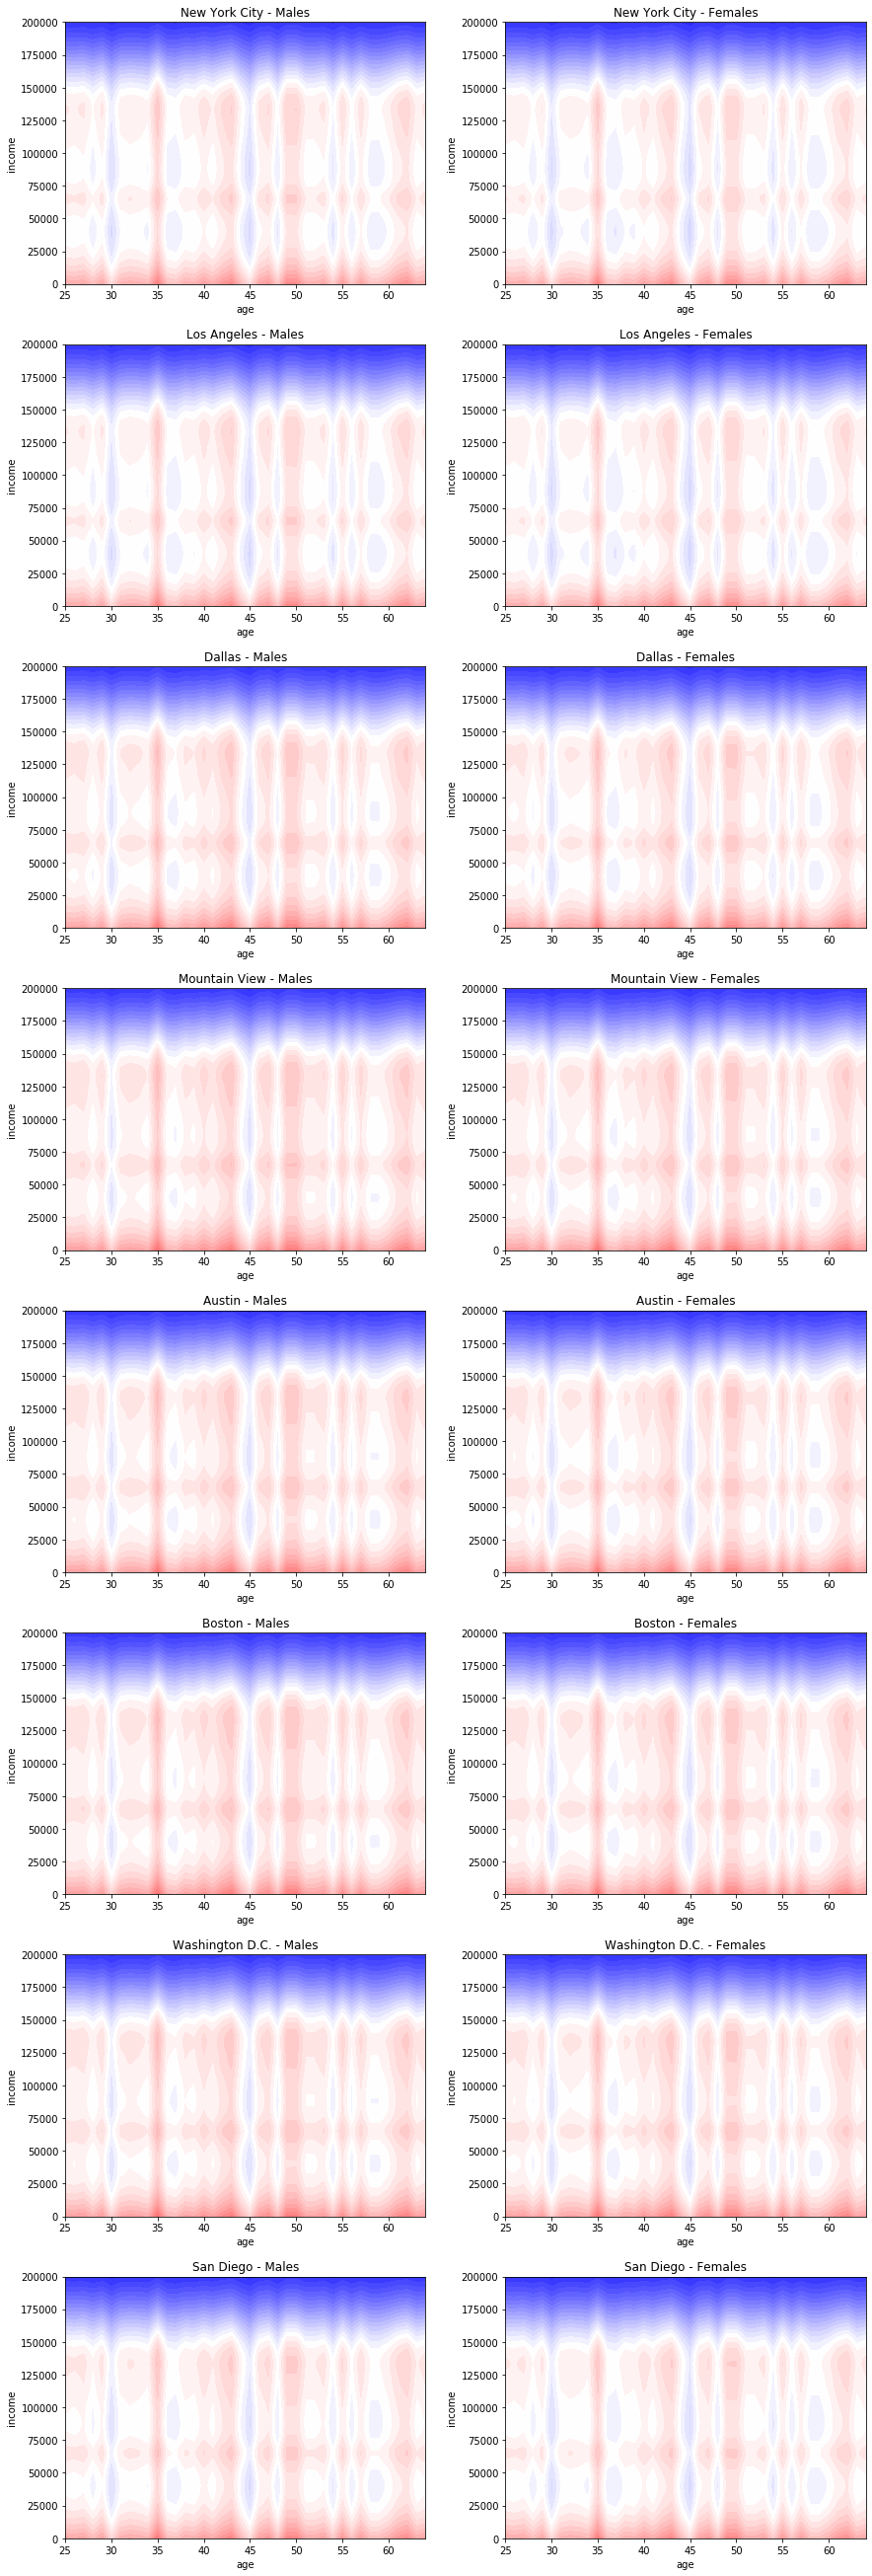

In [23]:
fig, axs = plt.subplots(prob_x0.shape[0], prob_x1.shape[0], figsize=(12, 36))
fig.tight_layout(h_pad=4, w_pad=5)

for c, city in zip(range(prob_x0.shape[0]), prob_x0.index):
    for g, gender in zip(range(prob_x1.shape[0]), prob_x1.index):
        z = (Z.applymap(lambda x: predict(city, gender, x[0], x[1])).to_numpy() - prob_y)/prob_y
        axs[c, g].contourf(
            X.to_numpy(),
            Y.to_numpy(),
            z,
            levels=[x for x in np.arange(-1.0, 1.0, 0.05)],
            cmap='bwr')
        axs[c, g].set_title('{} - {}s'.format(city, gender))
        axs[c, g].set_xlabel('age')
        axs[c, g].set_ylabel('income')
        axs[c, g].set_ylim([0, 200000])
        
plt.show()

The maps above present $p(y|x)$ for different cases, with _red_ shades denoting $p(y|x) > p(y)$, and conversly with $p(y|x) < p(y)$ described by _blue_ shades.

Even though the plots look rather similar, there are differences!

First of all, the vertical "fringes" are the result of keeping the `age` variable categorical (as opposed to  `income` defined through a pdf).
The fact that some values of `age` seem to have much elevated probablility of `illness` (e.g. 35, 48, ...) comparing to their neighbouring values, is a direct consequence of this choice.
Either way, we can see the pattern of `age` prevails across differnet values of `gender` and `city`, which suggests that this variable can be treated as independent from others.

Secondly, there seem to be only marginal differences regarding `gender`, despite `Male`s having their probablility of `illness` a bit higher.
There seem to be no evident correlation between `gender` and `income`, which justifies the usage of Naive Bayes model.

Finally, a non-confounding observation emerging from the data is the fact that `income` possesses the largest influence on the probablility of getting ill. Despite sublte influneces of both `gender` and `age`, and also `city`, the `income` matters above everything else.
In combination with all other variables, there is a persistent indication that any income abobe 150 kUSD, significantly reduces the probability of falling down with the illness (almost irrespectively of any of the other parameters).
